<a href="https://colab.research.google.com/github/Murphy-Mary/MyProject/blob/main/game_recommendations_on_steam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data


souce : https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam
!unzip /content/game-recommendations-on-steam.zip && rm /content/game-recommendations-on-steam.zip

Mounted at /content/gdrive
 89% 156M/176M [00:01<00:00, 127MB/s]
100% 176M/176M [00:01<00:00, 127MB/s]
Archive:  /content/game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


In [2]:
!apt-get update

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,013 kB]
Hit:13 http://ppa.launchpad.net/graphi

In [3]:
#Get Install the Java Development Kit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Spark lib -- address need to be change according to the current version of Spark: https://downloads.apache.org/spark/
!wget  http://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
#Unzip th Spark
!tar xf spark-3.3.2-bin-hadoop3.tgz
!rm spark-3.3.2-bin-hadoop3.tgz
#install findspark for Python
!pip install findspark
#Install extra lib(s)
!pip install xlrd
!pip install kaggle
!pip install kora

#import and set environment for spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import kora

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession


SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

--2023-03-04 02:08:02--  http://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.236.52, 64.50.233.100, 140.211.166.134, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.236.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M   119MB/s    in 2.4s    

2023-03-04 02:08:05 (119 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━

In [4]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np 
import pandas as pd
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

from pyspark.sql.functions import lit
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

#sc = pyspark.SparkContext()
sqlContext = pyspark.SQLContext(sc)
%matplotlib inline

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## data

In [6]:
game_tags = spark.read.json("/content/games_metadata.json")
game_tags.printSchema()
game_tags.show()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 10090|Call of Duty is b...|[Zombies, World W...|
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
|226560|Escape Dead Islan...|[Zombies, Adventu...|
|249050|Dungeon of the En...|[Roguelike, Strat...|
|250180|“METAL SLUG 3”, t...|[Arcade, Classic,...|
|253980|Experience incred...|[RPG, Action, Fan...|
|261550|A strategy/action...|[Medieval, Strate...|
|271850|                    |[Strategy, Simula...|
|282900|Packed with fast-...|[Anime, JRPG, Fem...|
| 19810|Lead a team of do...|  [Action, Tactical]|
| 15270|In a ferocious Ar...|[Horror, Action, ...|
| 21130|Build th

In [7]:
game_tags.count()

46068

In [8]:
game = spark.read.csv('/content/games.csv',header=True)
# c0ls = ["user_reviews","price_final","price_original","discount"]
game = game.withColumn("user_reviews",game.user_reviews.cast('double'))
game = game.withColumn("price_final",game.price_final.cast('double'))
game = game.withColumn("price_original",game.price_original.cast('double'))
game = game.withColumn("discount",game.discount.cast('double'))
# game = game.withColumn("mac",game.date_release.cast('Boolean'))
# game = game.withColumn("mac",game.date_release.cast('Boolean'))
# game = game.withColumn("win",game.date_release.cast('Boolean'))
# game = game.withColumn("steam_deck",game.date_release.cast('Boolean'))
game.printSchema()
game.show()

root
 |-- app_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: string (nullable = true)
 |-- win: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- user_reviews: double (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: string (nullable = true)

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 10090|Call of 

In [9]:
game.count()

46068

In [10]:
recomm = spark.read.csv('/content/recommendations.csv',header=True)
recomm = recomm.withColumn("date",recomm.date.cast('date'))
recomm = recomm.withColumn("is_recommended",recomm.is_recommended.cast('Boolean'))
recomm = recomm.withColumn("hours",recomm.hours.cast('double'))
recomm.printSchema()
recomm.show()

root
 |-- app_id: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)

+-------+-------+-----+----------+--------------+-----+-------+---------+
| app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+-------+-------+-----+----------+--------------+-----+-------+---------+
| 975370|      0|    0|2022-12-12|          true| 36.3|  19954|        0|
| 304390|      4|    0|2017-02-17|         false| 11.5|   1098|        1|
|1085660|      2|    0|2019-11-17|          true|336.5|  91207|        2|
| 703080|      0|    0|2022-09-23|          true| 27.4|  93054|        3|
| 526870|      0|    0|2021-01-10|          true|  7.9|   9106|        4|
| 306130|      0|    0|2021-10-10|          true|  8.6|  17622|        5|
| 238960|      0

In [11]:
recomm.orderBy(f.col("date")).show()

+------+-------+-----+----------+--------------+-----+-------+---------+
|app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+------+-------+-----+----------+--------------+-----+-------+---------+
|   220|      7|    2|2010-10-15|          true| 57.5|4558944|  9007734|
| 21690|      0|    0|2010-10-15|          true| 33.6|3676962|  8824678|
|    70|      0|    0|2010-10-15|          true|  5.8|3915561|  9668828|
| 12210|      0|    0|2010-10-15|          true| 97.4|2603260|  7867143|
|  8930|      0|    0|2010-10-15|          true|403.6| 300125|  6288229|
|   550|      8|    0|2010-10-15|          true|128.0|3016389|  5973921|
|  4000|     12|    2|2010-10-16|          true|866.8|4427300|  1411574|
|   220|      6|    0|2010-10-16|          true| 25.6|3119961|  8968553|
|    70|      0|    0|2010-10-16|          true| 16.4|3180449|  9683515|
| 22330|      2|    0|2010-10-16|          true| 19.9|2771215|  6936701|
|  4000|      4|    0|2010-10-16|          true|263

In [12]:
recomm.count()

10072270

In [13]:
user = spark.read.csv('/content/users.csv',header=True)
user.printSchema()
user.show()

root
 |-- user_id: string (nullable = true)
 |-- products: string (nullable = true)
 |-- reviews: string (nullable = true)

+-------+--------+-------+
|user_id|products|reviews|
+-------+--------+-------+
|5693478|     156|      1|
|3595958|     329|      3|
|1957593|     176|      2|
|2108293|      98|      2|
|2329878|     144|      2|
|3264015|     108|      1|
|3863136|     229|      1|
|4098027|     187|      1|
|4269643|    1824|      2|
|4473335|      12|      1|
|4494144|      91|      3|
|4509007|     207|      2|
|4598107|     315|      1|
|4627209|     130|      1|
|4642399|    1319|      2|
|4660331|    1903|      6|
|4959227|     352|      1|
|5191613|     107|      1|
|5573423|     587|      3|
| 372596|     321|      2|
+-------+--------+-------+
only showing top 20 rows



In [14]:
user.count()

5810794

# Prepare Section

In [15]:
game_tng = game.join(game_tags,["app_id"],"full")

In [16]:
game_tng.show()
# game_tng.select('tags').collect()[0][0][0]
# game_tng.describe().show()

+------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+
|app_id|               title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|
+------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+
|    10|      Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|          9.99|     0.0|      true|Play the world's ...|[Action, FPS, Mul...|
|    50|Half-Life: Opposi...|  1999-11-01|true| true| true|Overwhelmingly Po...|            95|     14057.0|       4.99|          4.99|     0.0|      true|Return to the Bla...|[FPS, Action, Cla...|
|   130|Ha

In [17]:
game_tng = game_tng.filter(game_tng.app_id.isNotNull()\
                           |game_tng.title.isNotNull()\
                           |game_tng.win.isNotNull()\
                           |game_tng.rating.isNotNull()\
                           |game_tng.price_final.isNotNull()\
                           |game_tng.price_original.isNotNull()\
                           |game_tng.description.isNotNull()\
                           |game_tng.tags.isNotNull()\
                           ).sort("app_id") 


In [18]:
game_tng.count()

46068

In [19]:
game_tng.show()

+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+
| app_id|                     title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                   description|                tags|
+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+
|     10|            Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|          9.99|     0.0|      true|          Play the world's ...|[Action, FPS, Mul...|
|1000000|                 ASCENXION|  2021-05-14|true|false|false|     Mostly Positive|            72|        22.0|       2.49|          9.9

-----------------------------------------------------


In [20]:
user_recc = recomm.join(user,["user_id"],"full")

In [21]:
user_recc.show()
# user_recc.describe().show()

+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|user_id| app_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|1000015| 252490|      0|    0|2022-04-12|          true|153.9|  1425042|      39|      2|
|1000015|1172620|      0|    0|2021-03-31|          true|178.2|  5204960|      39|      2|
|1000061|1222670|      0|    0|2021-08-30|          true|  8.2|  5368448|      18|      2|
|1000061| 641320|      0|    0|2021-11-09|          true|  2.2|  6373236|      18|      2|
|1000064| 431960|      0|    0|2022-05-24|          true|  6.1|  4967499|      17|      1|
|1000067|1237950|      0|    0|2022-04-16|          true|411.5|  7219262|      15|      1|
|1000070| 262060|      0|    0|2022-01-10|          true| 83.8|  7298313|       5|      1|
|1000073| 271590|      0|    0|2021-07-04|          true| 86.0|  1815935|      54|      2|

In [22]:
user_recc = user_recc.filter(user_recc.app_id.isNotNull()).sort("user_id") 

In [23]:
# user_recc.count()

In [24]:
user_recc.show()

+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|user_id| app_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|      0| 291550|      0|    0|2020-11-01|          true| 12.7|   104563|      54|      2|
|      0| 493520|      0|    0|2020-10-30|          true| 18.6|  4723256|      54|      2|
|      1| 466560|      0|    0|2017-11-23|          true| 11.7|  7425237|     114|      1|
|     10| 289070|      0|    0|2019-06-30|          true|195.9|  1504502|       9|      1|
|    100|1151340|      6|    0|2021-10-18|         false|121.2|  5551994|      26|      1|
|   1000| 457140|      0|    0|2021-12-17|          true|591.7|  9293917|     394|      1|
|  10000| 252490|      0|    0|2020-09-14|          true|149.1|  1854929|      12|      1|
| 100000| 252490|      0|    0|2021-08-05|          true|445.5|   482494|       6|      1|

In [25]:
all_data = game_tng.join(user_recc,["app_id"],"full")

In [26]:
all_data.printSchema()

root
 |-- app_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: string (nullable = true)
 |-- win: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- user_reviews: double (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: string (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- products: string (nullable = true)
 |-- reviews: string (nullable

In [27]:
# all_data.count()
all_data.show()
# app_id,title,win

+-------+----------------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
| app_id|                       title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+-------+----------------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|1000280|        Tower of Origin2-...|  2021-09-09|true|false|false|          Mixed|            68|        41.0|      13.99|         13.99|     0.0|      true|As the pro

In [28]:
#Drop Null
all_data = all_data.filter(all_data.app_id.isNotNull()|all_data.title.isNotNull()|all_data.win.isNotNull()).sort("app_id") 

In [29]:
# all_data.count()

In [30]:
all_data.show()

+-------+------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
| app_id|                   title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|user_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|     10|          Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|          9.99|     0.0

In [31]:
all_data.filter(all_data.date_release.isNull()).show()

+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|app_id|title|date_release|win|mac|linux|rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|description|tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+
+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+



In [32]:
all_data.groupBy("app_id",'title').count().filter("count > 1").sort("app_id").show()

+-------+--------------------+-----+
| app_id|               title|count|
+-------+--------------------+-----+
|1000360|       Hellish Quart| 2514|
|1005300|The Jackbox Party...| 2237|
|1007040|EARTH DEFENSE FOR...| 4759|
|  10090|Call of Duty: Wor...| 4994|
|1017180|      The Long Drive| 8770|
|1029690|      Sniper Elite 5| 4350|
|1029780|      Going Medieval| 6390|
|1032430|         Blood Trail| 2856|
|1036890|Shadow Warrior 3:...| 1413|
|1039880|    Hellsplit: Arena| 2225|
|1041320|        Lords Mobile|  554|
|1044720|   Farthest Frontier| 4265|
|1048370|       Idle Skilling|  986|
|1049410|        Superliminal| 9251|
|1049590|      Eternal Return| 8630|
| 105600|            Terraria|48595|
|1056640|Phantasy Star Onl...|  264|
|1057090|Ori and the Will ...|23952|
|1059990|      Trombone Champ| 1074|
|1061090|           Jump King| 3813|
+-------+--------------------+-----+
only showing top 20 rows



In [33]:
# all_data.write.parquet("/content/gdrive/MyDrive/sizeproject/allgamerecc.parquet")

# EDA Section

In [34]:
all_data.sort("price_original").show()

+-------+---------------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
| app_id|                      title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+-------+---------------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|1026760|              DepthQVR_AQUA|  2020-10-08|true|false|false|Mostly Positive|            77|        31.0|        0.0|           0.0|     0.0|      true|DepthQVR_AQUA 

## ---- top had user -----

In [35]:
count_data = all_data.select("app_id","title").groupBy("title").count()\
            .orderBy(f.col("count").desc())

In [36]:
count_data.show()

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|Counter-Strike: G...|172407|
|        No Man's Sky|150261|
|    Wallpaper Engine|149654|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|       Path of Exile|111576|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104751|
|          Brawlhalla| 99032|
|The Binding of Is...| 98643|
|            Lost Ark| 94162|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
|Sid Meier’s Civil...| 83188|
|Divinity: Origina...| 76651|
+--------------------+------+
only showing top 20 rows



In [37]:
count_data = count_data.toPandas()
count_data.head(10)

,title,count
0,Rust,251433
1,Counter-Strike: Global Offensive,172407
2,No Man's Sky,150261
3,Wallpaper Engine,149654
4,Grand Theft Auto V,148801
5,Fallout 4,148530
6,Call of Duty®: Modern Warfare® II,131361
7,Red Dead Redemption 2,117967
8,Arma 3,115925
9,Path of Exile,111576


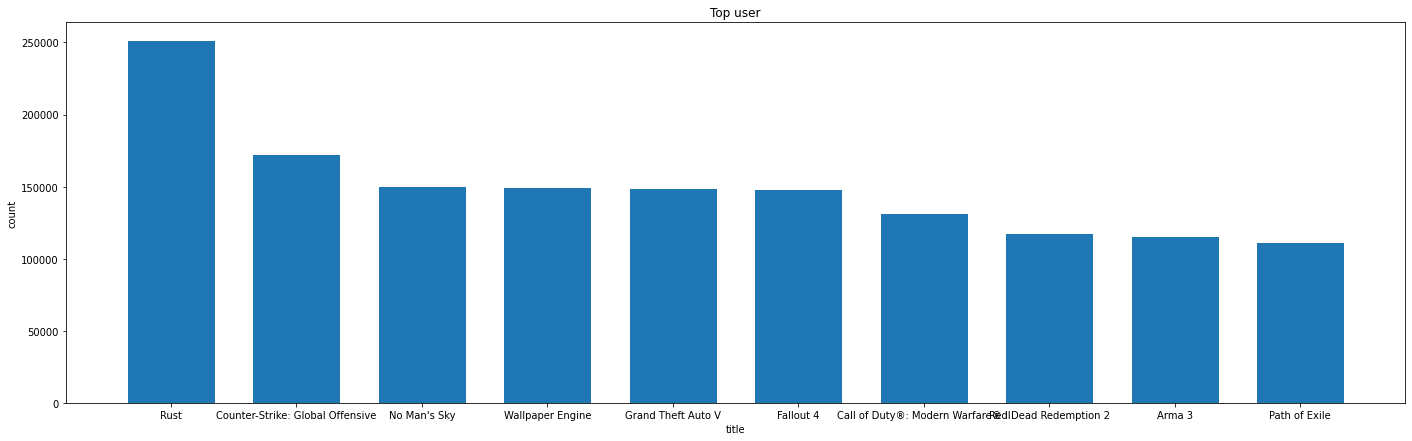

In [38]:
fig, ax = plt.subplots(figsize =(24,7))
ax.bar(count_data['title'][:10],count_data["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top user')
plt.xlabel('title')
plt.ylabel('count')
plt.show()

In [39]:
# count_data.plt.plot.bar(x='count')  

In [40]:
# count_datas = count_data.orderBy(f.col('count').desc())
# count_datas.show(20)

## ---- top buy games ----




In [41]:
price = all_data.groupBy("app_id","title").sum()

In [42]:
# all_data.select(f.col("app_id"),f.col("title"),f.col("price_original")).filter("app_id == 252490").count()
# all_data.select(f.col("app_id"),f.col("title"),f.col("price_original")).filter("app_id == 252490").show()

In [43]:
# from pyspark.sql.functions import *
price_ord = price.orderBy(f.col('sum(price_final)').desc())
price_ord.show(20)

+-------+--------------------+-----------------+--------------------+--------------------+-------------+--------------------+
| app_id|               title|sum(user_reviews)|    sum(price_final)| sum(price_original)|sum(discount)|          sum(hours)|
+-------+--------------------+-----------------+--------------------+--------------------+-------------+--------------------+
| 252490|                Rust| 1.81779270309E11|1.0054805670044027E7|1.0054805670044027E7|          0.0|  8.59341143000001E7|
| 275850|        No Man's Sky|  2.9884358463E10|    9014157.39002547|    9014157.39002547|          0.0| 1.971251109999999E7|
|1174180|Red Dead Redempti...|  3.9877918581E10|   7076840.330018253|   7076840.330018253|          0.0|1.8209469800000068E7|
|1091500|      Cyberpunk 2077|  5.6995528928E10|   6558586.720016322|   6558586.720016322|          0.0|1.1497222400000038E7|
|1938090|Call of Duty®: Mo...|  4.1615690244E10|   5975611.890018661|   9193956.390022406|    4597635.0|1.487167920000

In [44]:
price_ord = price_ord.toPandas()
price_ord.head(10)

,app_id,title,sum(user_reviews),sum(price_final),sum(price_original),sum(discount),sum(hours)
0,252490,Rust,1.817793e+11,1.005481e+07,1.005481e+07,0.0,85934114.3
1,275850,No Man's Sky,2.988436e+10,9.014157e+06,9.014157e+06,0.0,19712511.1
2,1174180,Red Dead Redemption 2,3.987792e+10,7.076840e+06,7.076840e+06,0.0,18209469.8
3,1091500,Cyberpunk 2077,5.699553e+10,6.558587e+06,6.558587e+06,0.0,11497222.4
4,1938090,Call of Duty®: Modern Warfare® II,4.161569e+10,5.975612e+06,9.193956e+06,4597635.0,14871679.2
5,1172620,Sea of Thieves,2.489735e+10,4.326558e+06,4.326558e+06,0.0,14566211.0
6,394360,Hearts of Iron IV,1.653934e+10,4.188992e+06,4.188992e+06,0.0,39739692.6
7,107410,Arma 3,1.809670e+10,3.476591e+06,3.476591e+06,0.0,35835060.4
8,435150,Divinity: Original Sin 2 - Definitive Edition,1.052257e+10,3.448528e+06,3.448528e+06,0.0,14152250.8
9,534380,Dying Light 2 Stay Human,5.494568e+09,3.314088e+06,3.314088e+06,0.0,3486578.2


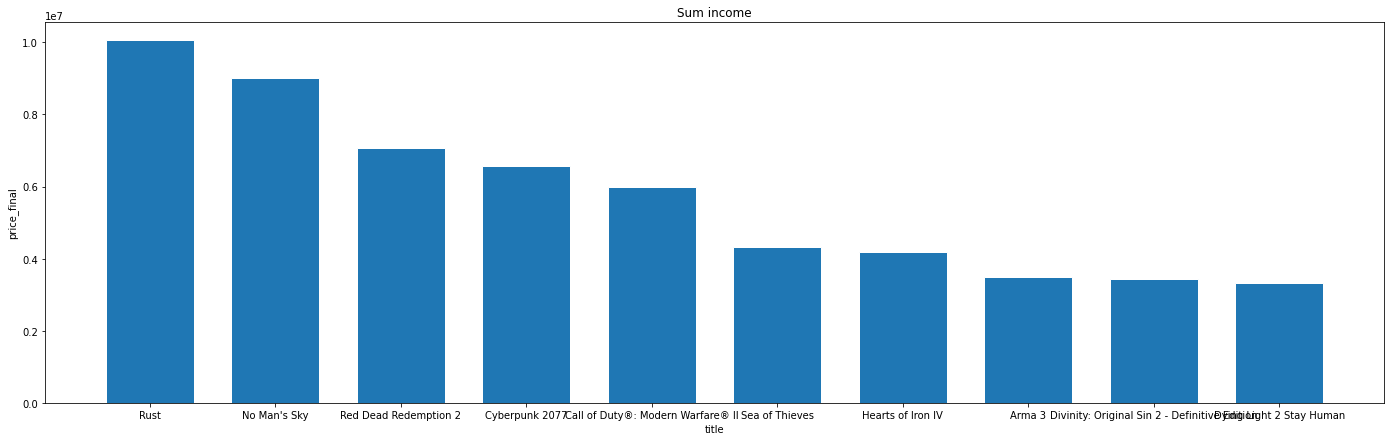

In [45]:
fig, ax = plt.subplots(figsize =(24,7))
ax.bar(price_ord['title'][:10],price_ord["sum(price_final)"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("Sum income")
plt.xlabel('title')
plt.ylabel('price_final')
plt.show()

## -----Top 10 popular games of 2022 with positive reviews-----

In [46]:
game.show()

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 10090|Call of Duty: Wor...|  2008-11-18|true|false|false|  Very Positive|            92|     37039.0|      19.99|         19.99|     0.0|      true|
| 13500|Prince of Persia:...|  2008-11-21|true|false|false|  Very Positive|            84|      2199.0|       9.99|          9.99|     0.0|      true|
| 22364|BRINK: Agents of ...|  2011-08-03|true|false|false|       Positive|            85|        21.0|       2.99|          2.99|     0.0|      true|
|113020|Monaco: What's Yo...|  2013-04-24|true| true| true|  Very Positive|            92|    

In [47]:
game_pos = game.select('app_id','title','date_release','user_reviews','positive_ratio').\
            filter((game["date_release"]>= lit('2022-01-01')) &(game["positive_ratio"]>=90))\
            .sort(f.col('user_reviews').desc(),f.col('positive_ratio').desc())

In [48]:
game_pos.show(10)

+-------+--------------------+------------+------------+--------------+
| app_id|               title|date_release|user_reviews|positive_ratio|
+-------+--------------------+------------+------------+--------------+
|1245620|          ELDEN RING|  2022-02-24|    481754.0|            91|
| 648800|                Raft|  2022-06-20|    218598.0|            93|
|1794680|   Vampire Survivors|  2022-10-20|    175903.0|            98|
|1332010|               Stray|  2022-07-19|    101109.0|            97|
| 990080|     Hogwarts Legacy|  2023-02-10|     84327.0|            93|
|1593500|          God of War|  2022-01-14|     65968.0|            97|
|1167630|            Teardown|  2022-04-21|     60815.0|            96|
|1817070|Marvel’s Spider-M...|  2022-08-12|     41232.0|            96|
|1313140|    Cult of the Lamb|  2022-08-11|     40135.0|            93|
|1290000| PowerWash Simulator|  2022-07-14|     29465.0|            97|
+-------+--------------------+------------+------------+--------

In [49]:
# game_pos = game_pos.toPandas()
# game_pos.head(10)

In [50]:
# fig, ax = plt.subplots(figsize =(24,10))
# ax.bar(game_pos['title'][:10],game_pos["positive_ratio"][:10],width=0.7, edgecolor="white", linewidth=1)
# # ax.set(xlim=(0, 8),ylim=(0, 8))
# plt.title("Top 10 popular games of 2022 with positive reviews")
# plt.xlabel('title')
# plt.ylabel('positive_ratio')
# plt.show()

## ----Top 10 popular games of 2022 with mixed or lower reviews----


In [51]:
game_pos2 = game.select('app_id','title','date_release','user_reviews','positive_ratio').\
            filter((game["date_release"]>= lit('2022-01-01')) &(game["positive_ratio"] <= 70))\
            .sort(f.col('user_reviews').desc(),f.col('positive_ratio').desc())

In [52]:
game_pos2.show(10)

+-------+--------------------+------------+------------+--------------+
| app_id|               title|date_release|user_reviews|positive_ratio|
+-------+--------------------+------------+------------+--------------+
|1938090|Call of Duty®: Mo...|  2022-10-27|    316804.0|            62|
|1832640| Mirror 2: Project X|  2022-01-20|    110981.0|            26|
|1811260|  EA SPORTS™ FIFA 23|  2022-09-29|     67263.0|            50|
|1361210|Warhammer 40000: ...|  2022-11-30|     54741.0|            54|
| 674020|         World War 3|  2022-12-10|     49594.0|            54|
| 868270| The Cycle: Frontier|  2022-06-08|     39025.0|            61|
|1418630|        Dread Hunger|  2022-01-26|     38500.0|            61|
|1544020|The Callisto Prot...|  2022-12-01|     21737.0|            62|
|1962663|Call of Duty®: Wa...|  2022-11-16|     19770.0|            34|
| 529340|          Victoria 3|  2022-10-25|     19223.0|            67|
+-------+--------------------+------------+------------+--------

In [53]:
# game_pos2 = game_pos2.toPandas()
# game_pos2.head(10)

In [54]:
# fig, ax = plt.subplots(figsize =(24,10))
# ax.bar(game_pos2['title'][:10],game_pos2["user_reviews"][:10],width=0.7, edgecolor="white", linewidth=1)
# # ax.set(xlim=(0, 8),ylim=(0, 8))
# plt.title("Top 10 popular games of 2022 with mixed or lower reviews")
# plt.xlabel('title')
# plt.ylabel('user_reviews')
# plt.show()

## ---- Top Genre popular ----

In [55]:
game_tags.printSchema()
game_tags.show()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 10090|Call of Duty is b...|[Zombies, World W...|
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
|226560|Escape Dead Islan...|[Zombies, Adventu...|
|249050|Dungeon of the En...|[Roguelike, Strat...|
|250180|“METAL SLUG 3”, t...|[Arcade, Classic,...|
|253980|Experience incred...|[RPG, Action, Fan...|
|261550|A strategy/action...|[Medieval, Strate...|
|271850|                    |[Strategy, Simula...|
|282900|Packed with fast-...|[Anime, JRPG, Fem...|
| 19810|Lead a team of do...|  [Action, Tactical]|
| 15270|In a ferocious Ar...|[Horror, Action, ...|
| 21130|Build th

In [56]:
genre = all_data.select(f.col("app_id"),f.col("title"),f.col("price_final"),f.explode(f.col("tags")))

In [57]:
ganre_2 = genre.orderBy(f.col('col').desc())
ganre_2.show(10)

+-------+--------------------+-----------+-------+
| app_id|               title|price_final|    col|
+-------+--------------------+-----------+-------+
|1012530|           Soccering|       0.29|eSports|
|1100990|            Aimbeast|       4.99|eSports|
|1021770|      Wanba Warriors|       4.99|eSports|
|1000870|  On Target VR Darts|       7.99|eSports|
|1029550|        Torque Drift|        0.0|eSports|
|1004330|         My Exercise|       2.99|eSports|
|1033640|      SYNAPTIC DRIVE|      29.99|eSports|
|1058830|      Spin Rhythm XD|      19.99|eSports|
|1097130|  Circuit Superstars|      19.99|eSports|
|1061100|Hunter's Arena: L...|      19.99|eSports|
+-------+--------------------+-----------+-------+
only showing top 10 rows



In [58]:
# genre.show() all_data.groupBy("title").count().filter("count > 100")
ganre_3 = genre.select('title','col').groupBy("col").count().orderBy(f.col('count').desc())
# .filter(ganre_2["col"] != lit("eSports")).orderBy(f.col('col').desc())
ganre_3.show(10)

+------------+-------+
|         col|  count|
+------------+-------+
|Singleplayer|8073844|
|      Action|7864989|
| Multiplayer|7066100|
|   Adventure|5869254|
|       Co-op|5015556|
|  Open World|4878963|
|First-Person|4628802|
| Atmospheric|4541618|
|  Simulation|3816806|
|     Sandbox|3625098|
+------------+-------+
only showing top 10 rows



In [59]:
ganre_3 = ganre_3.toPandas()
ganre_3.head(10)

,col,count
0,Singleplayer,8073844
1,Action,7864989
2,Multiplayer,7066100
3,Adventure,5869254
4,Co-op,5015556
5,Open World,4878963
6,First-Person,4628802
7,Atmospheric,4541618
8,Simulation,3816806
9,Sandbox,3625098


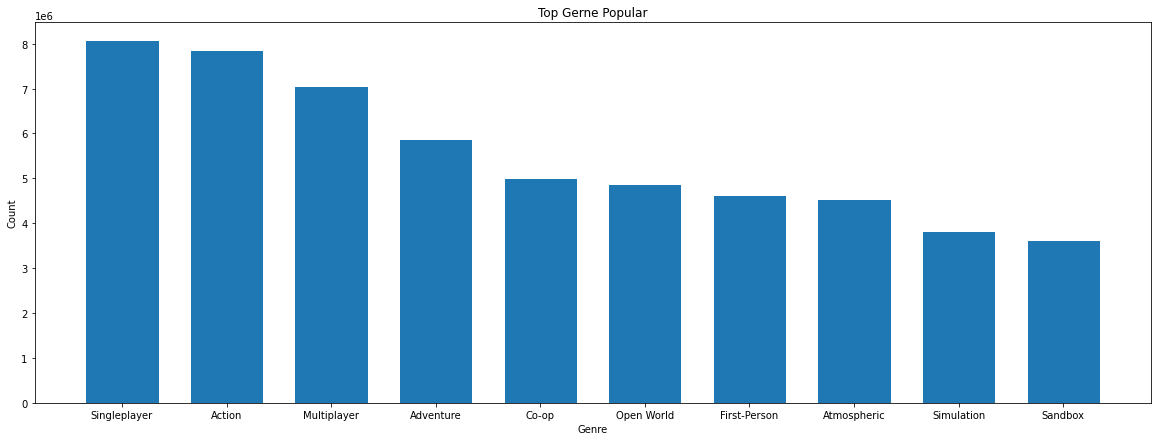

In [60]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(ganre_3['col'][:10],ganre_3["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Gerne Popular')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

### Top Gerne Free game

In [61]:
ganre_4 = ganre_2.select('title','col').filter("price_final == 0").groupBy("col").count().orderBy(f.col('count').desc())

In [62]:
ganre_4.show(10)

+--------------------+-------+
|                 col|  count|
+--------------------+-------+
|         Multiplayer|1317916|
|              Action|1231137|
|        Free to Play|1211716|
|               Co-op| 921527|
|        Singleplayer| 822122|
|           Adventure| 821258|
|                 PvP| 745879|
|Massively Multipl...| 744707|
|        Online Co-Op| 651796|
|                 RPG| 626124|
+--------------------+-------+
only showing top 10 rows



In [63]:
ganre_4 = ganre_4.toPandas()
ganre_4.head(10)

,col,count
0,Multiplayer,1317916
1,Action,1231137
2,Free to Play,1211716
3,Co-op,921527
4,Singleplayer,822122
5,Adventure,821258
6,PvP,745879
7,Massively Multiplayer,744707
8,Online Co-Op,651796
9,RPG,626124


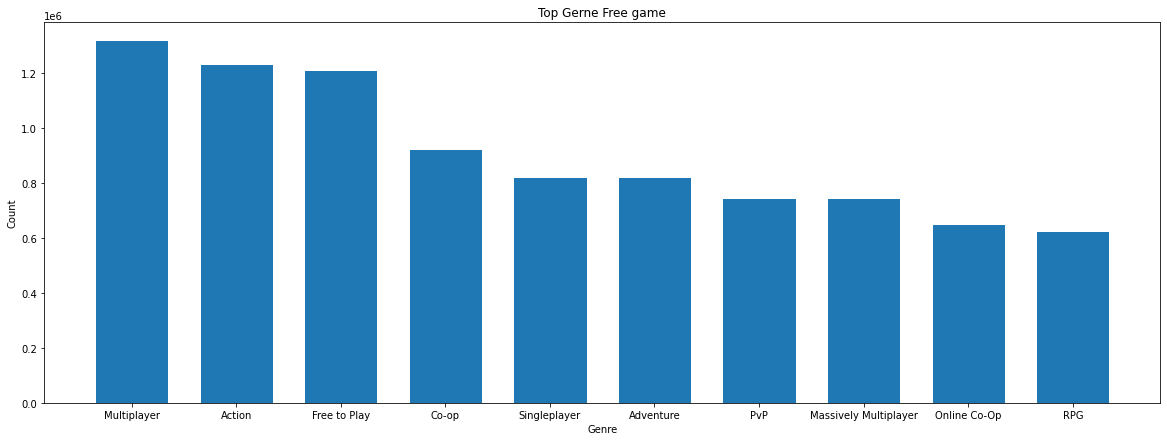

In [64]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(ganre_4['col'][:10],ganre_4["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Gerne Free game')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

### Top Gerne Paid game

In [65]:
ganre_5 = ganre_2.select('title','col').filter("price_final != 0").groupBy("col").count().orderBy(f.col('count').desc())

In [66]:
ganre_5.show(10)

+------------+-------+
|         col|  count|
+------------+-------+
|Singleplayer|7251722|
|      Action|6633852|
| Multiplayer|5748184|
|   Adventure|5047996|
|  Open World|4364787|
| Atmospheric|4242736|
|First-Person|4138470|
|       Co-op|4094029|
|  Simulation|3360413|
|       Indie|3267687|
+------------+-------+
only showing top 10 rows



In [67]:
ganre_5 = ganre_5.toPandas()
ganre_5.head(10)

,col,count
0,Singleplayer,7251722
1,Action,6633852
2,Multiplayer,5748184
3,Adventure,5047996
4,Open World,4364787
5,Atmospheric,4242736
6,First-Person,4138470
7,Co-op,4094029
8,Simulation,3360413
9,Indie,3267687


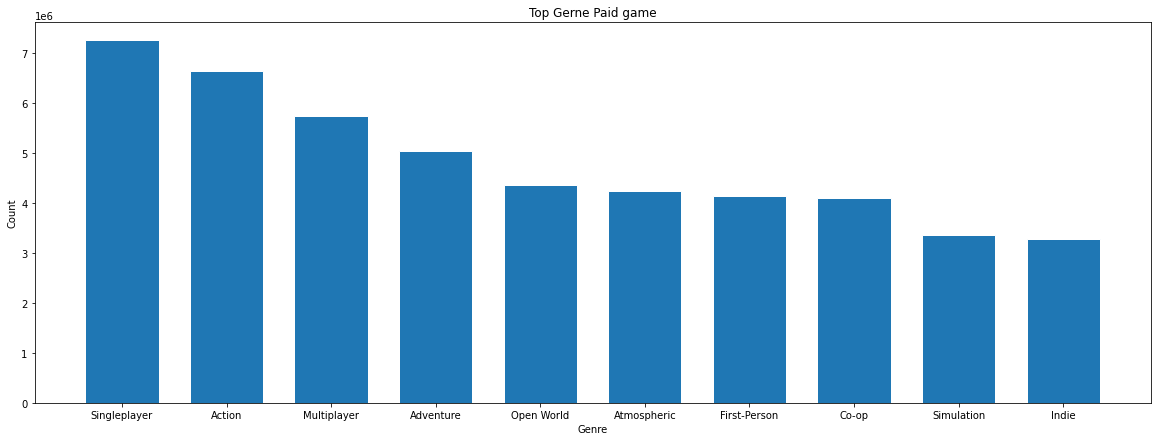

In [68]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(ganre_5['col'][:10],ganre_5["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Gerne Paid game')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

### Top Gerne eSpots game

In [69]:
ganre_6 =  ganre_2.select('title').filter("col == 'eSports'").groupBy("title").count().orderBy(f.col('count').desc())

In [70]:
ganre_6.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|Counter-Strike: G...|172407|
|          Brawlhalla| 99032|
|              Dota 2| 61358|
|              SMITE®| 50595|
|Yu-Gi-Oh! Master ...| 18817|
|  EA SPORTS™ FIFA 23| 16772|
|            MX Bikes|  6447|
|Freestyle 2: Stre...|  6368|
|            NBA 2K23|  5685|
|     eFootball™ 2023|  5036|
+--------------------+------+
only showing top 10 rows



In [71]:
ganre_6 = ganre_6.toPandas()
ganre_6.head(10)

,title,count
0,Counter-Strike: Global Offensive,172407
1,Brawlhalla,99032
2,Dota 2,61358
3,SMITE®,50595
4,Yu-Gi-Oh! Master Duel,18817
5,EA SPORTS™ FIFA 23,16772
6,MX Bikes,6447
7,Freestyle 2: Street Basketball,6368
8,NBA 2K23,5685
9,eFootball™ 2023,5036


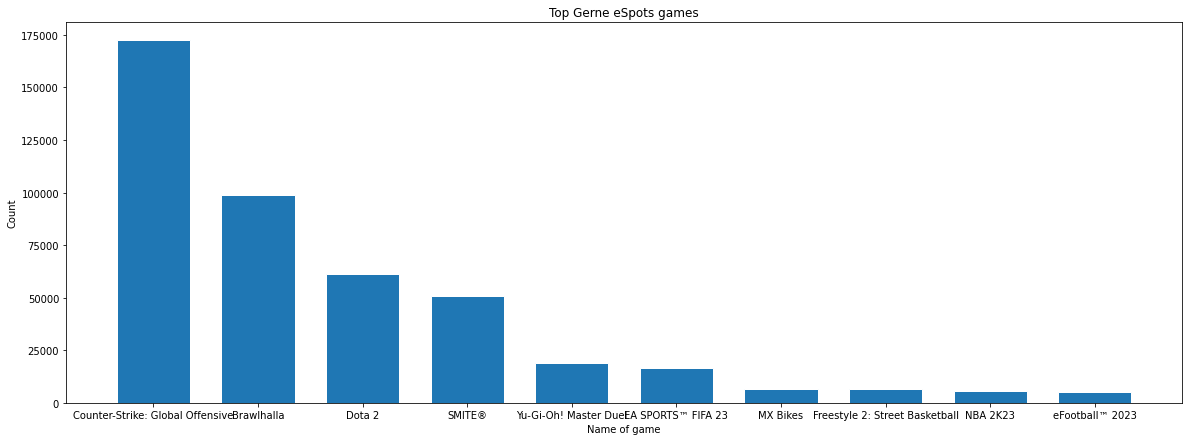

In [72]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(ganre_6['title'][:10],ganre_6["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Gerne eSpots games')
plt.xlabel('Name of game')
plt.ylabel('Count')
plt.show()

## ----Top Gerane Games ----

In [73]:
ganre_3.head(10)

,col,count
0,Singleplayer,8073844
1,Action,7864989
2,Multiplayer,7066100
3,Adventure,5869254
4,Co-op,5015556
5,Open World,4878963
6,First-Person,4628802
7,Atmospheric,4541618
8,Simulation,3816806
9,Sandbox,3625098


### By Action

In [74]:
top_game1 = ganre_2.select('title').filter("col == 'Action'").groupBy("title").count().orderBy(f.col('count').desc())

In [75]:
top_game1.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|Counter-Strike: G...|172407|
|        No Man's Sky|150261|
|    Wallpaper Engine|149654|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|       Path of Exile|111576|
+--------------------+------+
only showing top 10 rows



In [76]:
top_game1 = top_game1.toPandas()
top_game1.head(10)

,title,count
0,Rust,251433
1,Counter-Strike: Global Offensive,172407
2,No Man's Sky,150261
3,Wallpaper Engine,149654
4,Grand Theft Auto V,148801
5,Fallout 4,148530
6,Call of Duty®: Modern Warfare® II,131361
7,Red Dead Redemption 2,117967
8,Arma 3,115925
9,Path of Exile,111576


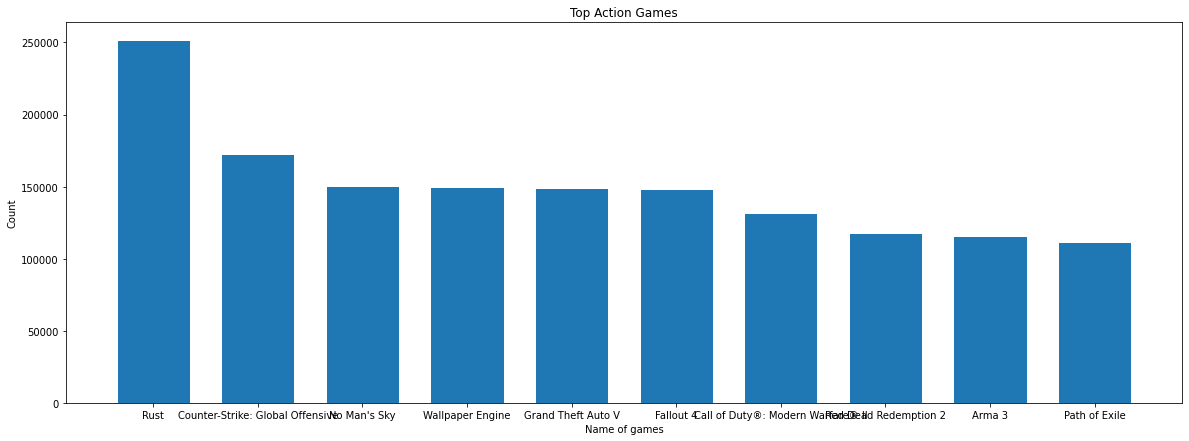

In [77]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game1['title'][:10],top_game1["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Action Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Singleplayer

In [78]:
top_game2 = ganre_2.select('title').filter("col == 'Singleplayer'").groupBy("title").count().orderBy(f.col('count').desc())

In [79]:
top_game2.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|        No Man's Sky|150261|
|    Wallpaper Engine|149654|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|       Path of Exile|111576|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
+--------------------+------+
only showing top 10 rows



In [80]:
top_game2 = top_game2.toPandas()
top_game2.head(10)

,title,count
0,No Man's Sky,150261
1,Wallpaper Engine,149654
2,Grand Theft Auto V,148801
3,Fallout 4,148530
4,Call of Duty®: Modern Warfare® II,131361
5,Red Dead Redemption 2,117967
6,Arma 3,115925
7,Path of Exile,111576
8,Cyberpunk 2077,109328
9,Sea of Thieves,108191


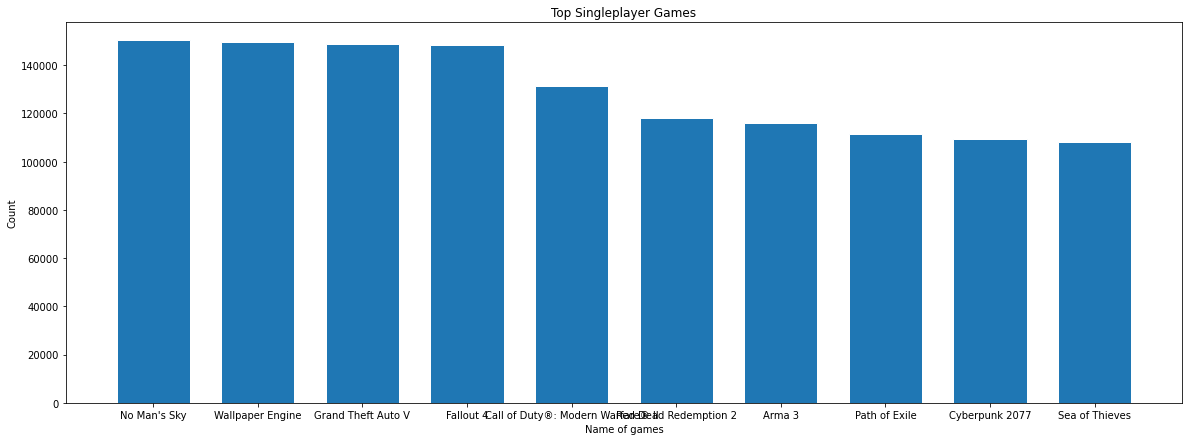

In [81]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game2['title'][:10],top_game2["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Singleplayer Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Multiplayer

In [82]:
top_game3 = ganre_2.select('title').filter("col == 'Multiplayer'").groupBy("title").count().orderBy(f.col('count').desc())

In [83]:
top_game3.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|Counter-Strike: G...|172407|
|        No Man's Sky|150261|
|  Grand Theft Auto V|148801|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|       Path of Exile|111576|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104751|
+--------------------+------+
only showing top 10 rows



In [84]:
top_game3 = top_game3.toPandas()
top_game3.head(10)

,title,count
0,Rust,251433
1,Counter-Strike: Global Offensive,172407
2,No Man's Sky,150261
3,Grand Theft Auto V,148801
4,Call of Duty®: Modern Warfare® II,131361
5,Red Dead Redemption 2,117967
6,Arma 3,115925
7,Path of Exile,111576
8,Sea of Thieves,108191
9,Hearts of Iron IV,104751


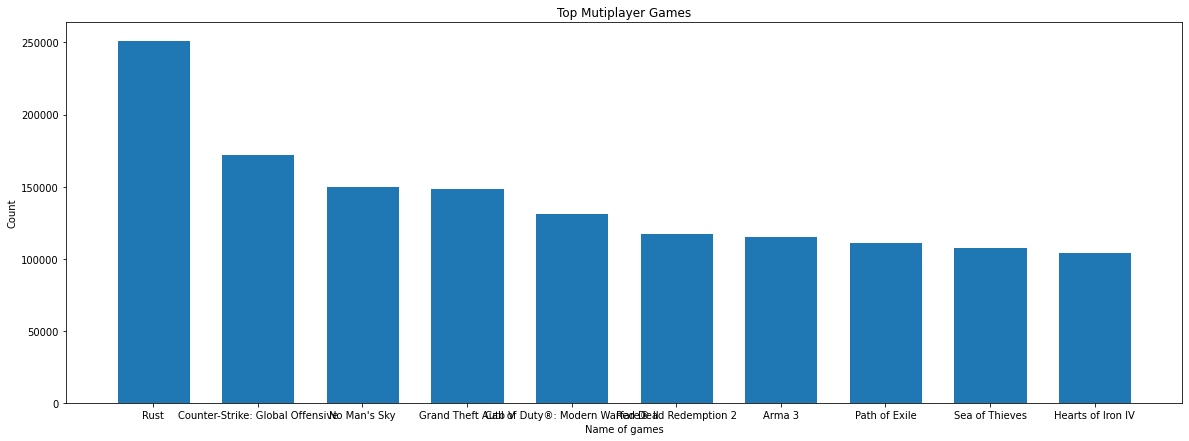

In [85]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game3['title'][:10],top_game3["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Mutiplayer Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Co-op

In [86]:
top_game4 = ganre_2.select('title').filter("col == 'Co-op'").groupBy("title").count().orderBy(f.col('count').desc())

In [87]:
top_game4.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|Counter-Strike: G...|172407|
|  Grand Theft Auto V|148801|
|Call of Duty®: Mo...|131361|
|              Arma 3|115925|
|       Path of Exile|111576|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104751|
|          Brawlhalla| 99032|
|The Binding of Is...| 98643|
+--------------------+------+
only showing top 10 rows



In [88]:
top_game4 = top_game4.toPandas()
top_game4.head(10)

,title,count
0,Rust,251433
1,Counter-Strike: Global Offensive,172407
2,Grand Theft Auto V,148801
3,Call of Duty®: Modern Warfare® II,131361
4,Arma 3,115925
5,Path of Exile,111576
6,Sea of Thieves,108191
7,Hearts of Iron IV,104751
8,Brawlhalla,99032
9,The Binding of Isaac: Rebirth,98643


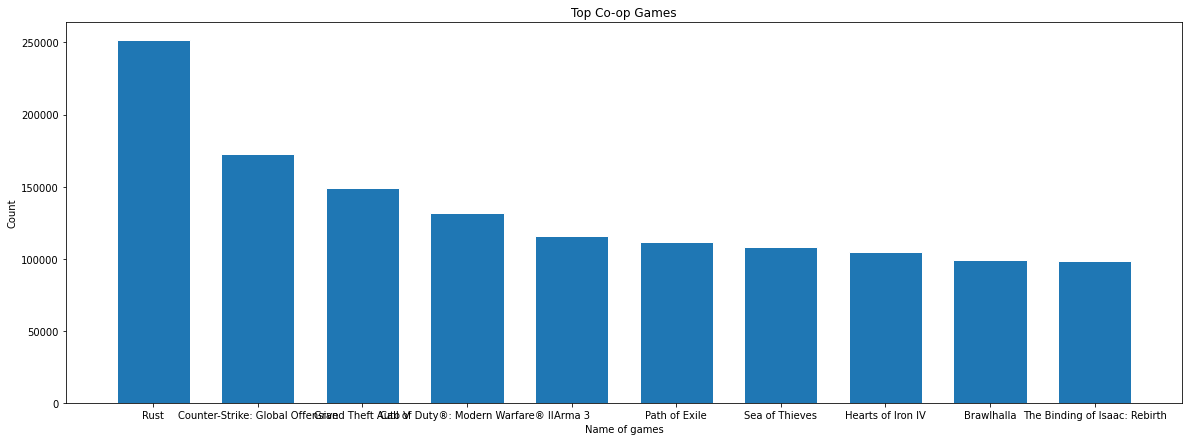

In [89]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game4['title'][:10],top_game4["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Co-op Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Adventure

In [90]:
top_game5 = ganre_2.select('title').filter("col == 'Adventure'").groupBy("title").count().orderBy(f.col('count').desc())

In [91]:
top_game5.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|        No Man's Sky|150261|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Red Dead Redempti...|117967|
|       Path of Exile|111576|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|            Lost Ark| 94162|
|        BeamNG.drive| 90970|
+--------------------+------+
only showing top 10 rows



In [92]:
top_game5 = top_game5.toPandas()
top_game5.head(10)

,title,count
0,Rust,251433
1,No Man's Sky,150261
2,Grand Theft Auto V,148801
3,Fallout 4,148530
4,Red Dead Redemption 2,117967
5,Path of Exile,111576
6,Cyberpunk 2077,109328
7,Sea of Thieves,108191
8,Lost Ark,94162
9,BeamNG.drive,90970


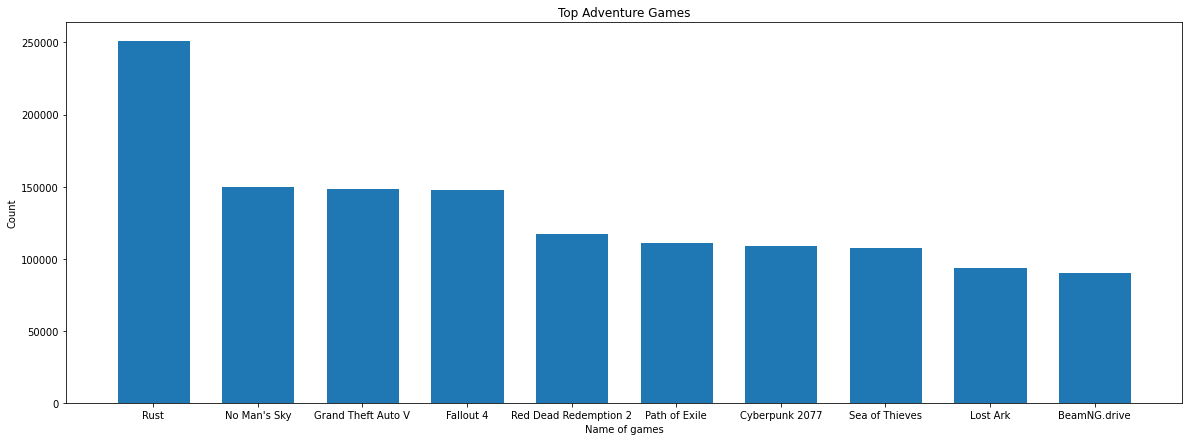

In [93]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game5['title'][:10],top_game5["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Adventure Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By First-Person

In [94]:
top_game6 = ganre_2.select('title').filter("col == 'First-Person'").groupBy("title").count().orderBy(f.col('count').desc())

In [95]:
top_game6.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|Counter-Strike: G...|172407|
|        No Man's Sky|150261|
|    Wallpaper Engine|149654|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|      Cyberpunk 2077|109328|
+--------------------+------+
only showing top 10 rows



In [96]:
top_game6 = top_game6.toPandas()
top_game6.head(10)

,title,count
0,Rust,251433
1,Counter-Strike: Global Offensive,172407
2,No Man's Sky,150261
3,Wallpaper Engine,149654
4,Grand Theft Auto V,148801
5,Fallout 4,148530
6,Call of Duty®: Modern Warfare® II,131361
7,Red Dead Redemption 2,117967
8,Arma 3,115925
9,Cyberpunk 2077,109328


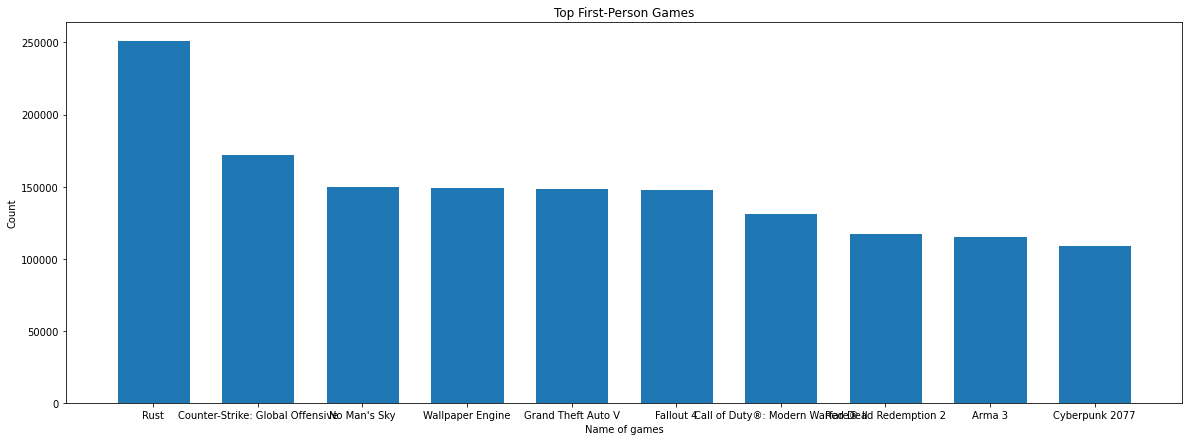

In [97]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game6['title'][:10],top_game6["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top First-Person Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Open World

In [98]:
top_game7 = ganre_2.select('title').filter("col == 'Open World'").groupBy("title").count().orderBy(f.col('count').desc())

In [99]:
top_game7.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|        No Man's Sky|150261|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104751|
|        BeamNG.drive| 90970|
+--------------------+------+
only showing top 10 rows



In [100]:
top_game7 =top_game7.toPandas()
top_game7.head(10)

,title,count
0,Rust,251433
1,No Man's Sky,150261
2,Grand Theft Auto V,148801
3,Fallout 4,148530
4,Red Dead Redemption 2,117967
5,Arma 3,115925
6,Cyberpunk 2077,109328
7,Sea of Thieves,108191
8,Hearts of Iron IV,104751
9,BeamNG.drive,90970


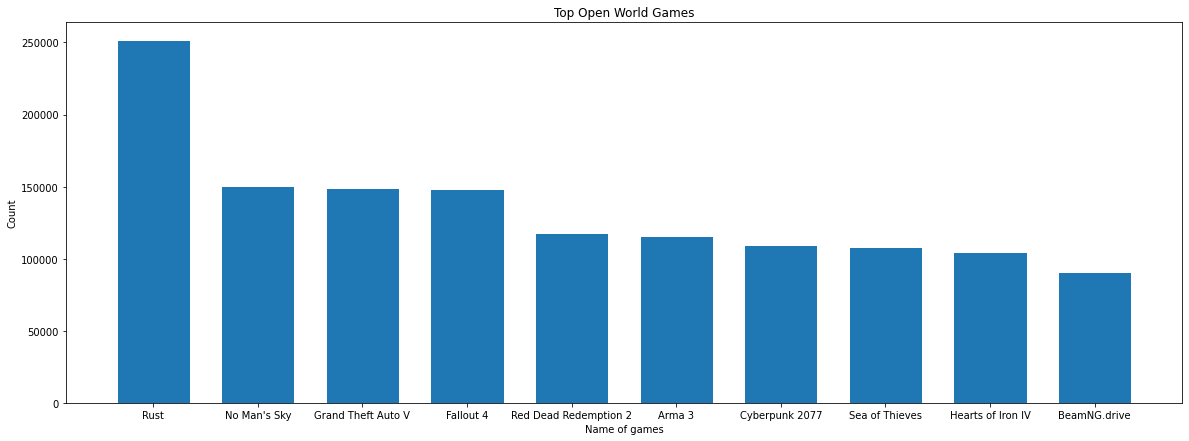

In [101]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game7['title'][:10],top_game7["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Open World Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Atmospheric

In [102]:
top_game8 = ganre_2.select('title').filter("col == 'Atmospheric'").groupBy("title").count().orderBy(f.col('count').desc())

In [103]:
top_game8.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|        No Man's Sky|150261|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|The Binding of Is...| 98643|
|Sid Meier’s Civil...| 83188|
|The Elder Scrolls...| 68834|
+--------------------+------+
only showing top 10 rows



In [104]:
top_game8 = top_game8.toPandas()
top_game8.head(10)

,title,count
0,No Man's Sky,150261
1,Grand Theft Auto V,148801
2,Fallout 4,148530
3,Call of Duty®: Modern Warfare® II,131361
4,Red Dead Redemption 2,117967
5,Cyberpunk 2077,109328
6,Sea of Thieves,108191
7,The Binding of Isaac: Rebirth,98643
8,Sid Meier’s Civilization® VI,83188
9,The Elder Scrolls® Online,68834


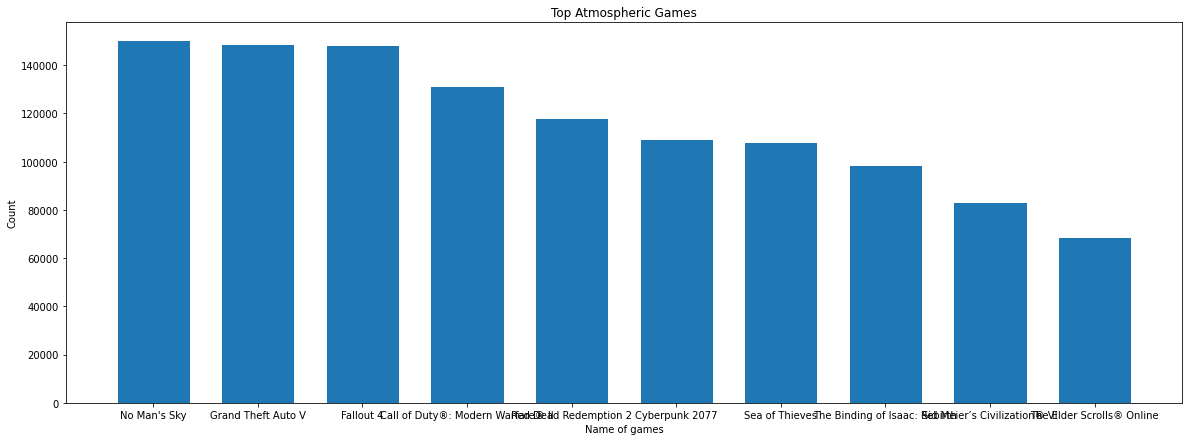

In [105]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game8['title'][:10],top_game8["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Atmospheric Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Simulation

In [106]:
top_game9 = ganre_2.select('title').filter("col == 'Simulation'").groupBy("title").count().orderBy(f.col('count').desc())

In [107]:
top_game9.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|        No Man's Sky|150261|
|              Arma 3|115925|
|   Hearts of Iron IV|104751|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
|Sid Meier’s Civil...| 83188|
|     Space Engineers| 76197|
|        Satisfactory| 68495|
|Tom Clancy's Rain...| 67570|
+--------------------+------+
only showing top 10 rows



In [108]:
top_game9 = top_game9.toPandas()
top_game9.head(10)

,title,count
0,Rust,251433
1,No Man's Sky,150261
2,Arma 3,115925
3,Hearts of Iron IV,104751
4,BeamNG.drive,90970
5,VRChat,87365
6,Sid Meier’s Civilization® VI,83188
7,Space Engineers,76197
8,Satisfactory,68495
9,Tom Clancy's Rainbow Six® Siege,67570


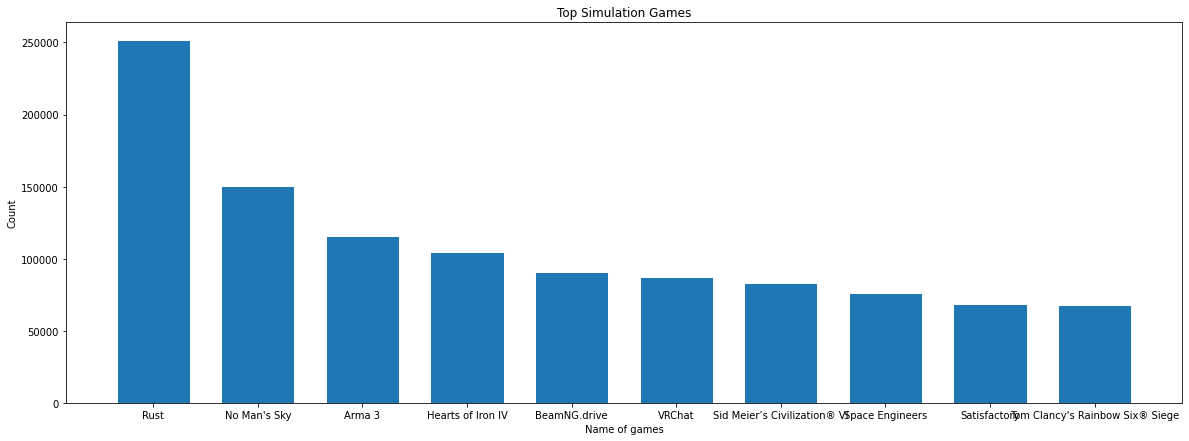

In [109]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game9['title'][:10],top_game9["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Simulation Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### By Sandbox

In [110]:
top_game10 = ganre_2.select('title').filter("col == 'Sandbox'").groupBy("title").count().orderBy(f.col('count').desc())

In [111]:
top_game10.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251433|
|        No Man's Sky|150261|
|    Wallpaper Engine|149654|
|  Grand Theft Auto V|148801|
|           Fallout 4|148530|
|Red Dead Redempti...|117967|
|              Arma 3|115925|
|   Hearts of Iron IV|104751|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
+--------------------+------+
only showing top 10 rows



In [112]:
top_game10 = top_game10.toPandas()
top_game10.head(10)

,title,count
0,Rust,251433
1,No Man's Sky,150261
2,Wallpaper Engine,149654
3,Grand Theft Auto V,148801
4,Fallout 4,148530
5,Red Dead Redemption 2,117967
6,Arma 3,115925
7,Hearts of Iron IV,104751
8,BeamNG.drive,90970
9,VRChat,87365


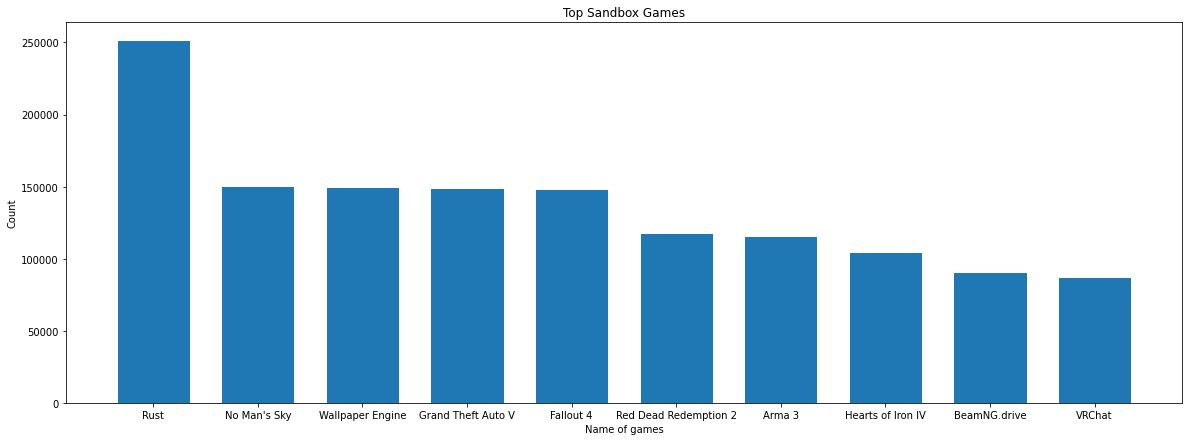

In [113]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(top_game10['title'][:10],top_game10["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('Top Sandbox Games')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

## ----Top user by time----

In [114]:
trend = all_data.groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [115]:
trend.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|                Rust|  2018-02-08|251433|
|Counter-Strike: G...|  2012-08-21|172407|
|        No Man's Sky|  2016-08-12|150261|
|    Wallpaper Engine|  2018-11-01|149654|
|  Grand Theft Auto V|  2015-04-13|148801|
|           Fallout 4|  2015-11-09|148530|
|Call of Duty®: Mo...|  2022-10-27|131361|
|Red Dead Redempti...|  2019-12-05|117967|
|              Arma 3|  2013-09-12|115925|
|       Path of Exile|  2013-10-23|111576|
+--------------------+------------+------+
only showing top 10 rows



In [116]:
trend = trend.toPandas()
trend.head(10)

,title,date_release,count
0,Rust,2018-02-08,251433
1,Counter-Strike: Global Offensive,2012-08-21,172407
2,No Man's Sky,2016-08-12,150261
3,Wallpaper Engine,2018-11-01,149654
4,Grand Theft Auto V,2015-04-13,148801
5,Fallout 4,2015-11-09,148530
6,Call of Duty®: Modern Warfare® II,2022-10-27,131361
7,Red Dead Redemption 2,2019-12-05,117967
8,Arma 3,2013-09-12,115925
9,Path of Exile,2013-10-23,111576


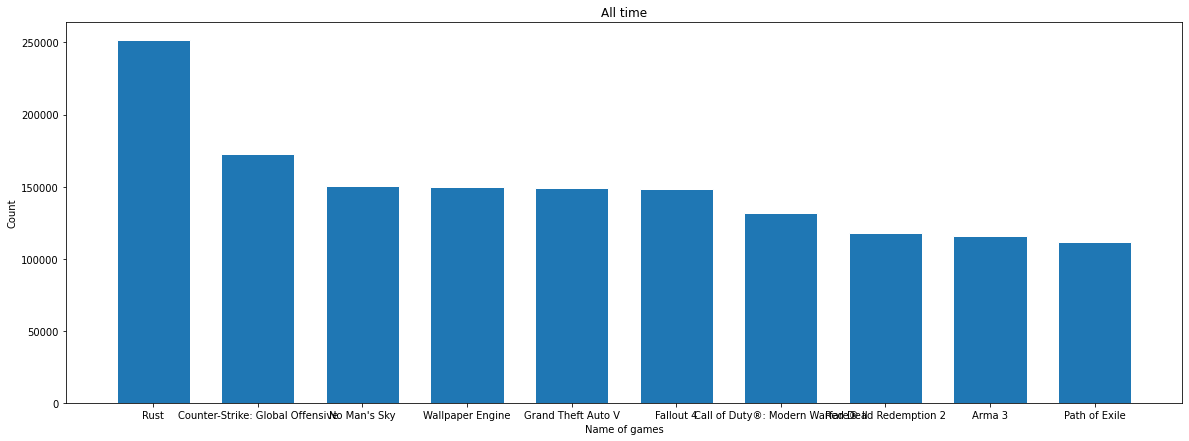

In [117]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(trend['title'][:10],trend["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title('All time')
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### Before 2000's


In [118]:
trend1 = all_data.filter((f.year('date_release') < lit('2000'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [119]:
trend1.show()

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|           Half-Life|  1998-11-08|41466|
|Carmageddon Max Pack|  1997-06-30|    1|
|Team Fortress Cla...|  1999-04-01|    1|
|Legacy of Kain: S...|  1999-09-08|    1|
|              POSTAL|  1997-11-14|    1|
|Half-Life: Opposi...|  1999-11-01|    1|
+--------------------+------------+-----+



In [120]:
trend1= trend1.toPandas()
trend1.head(10)

,title,date_release,count
0,Half-Life,1998-11-08,41466
1,Carmageddon Max Pack,1997-06-30,1
2,Legacy of Kain: Soul Reaver,1999-09-08,1
3,Team Fortress Classic,1999-04-01,1
4,POSTAL,1997-11-14,1
5,Half-Life: Opposing Force,1999-11-01,1


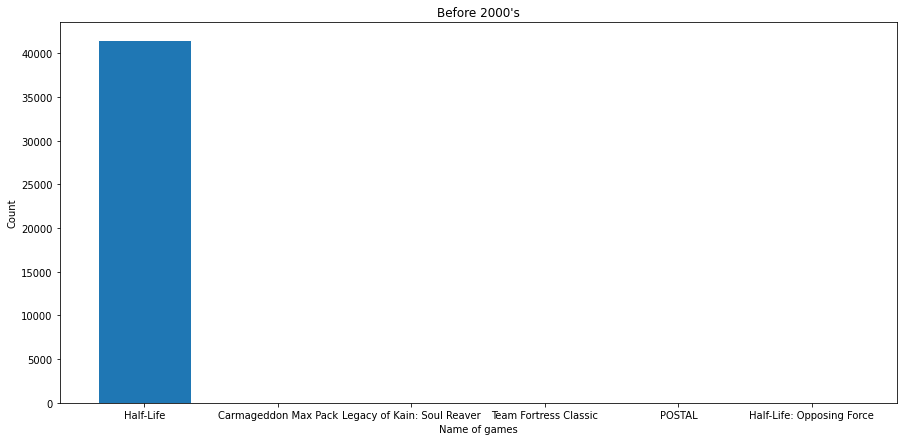

In [121]:
fig, ax = plt.subplots(figsize =(15,7))
ax.bar(trend1['title'][:10],trend1["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("Before 2000's")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### 2000's - 2010's


In [122]:
trend2 = all_data.filter((f.year('date_release') > lit('2000')) &(f.year('date_release') <= lit('2010'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [123]:
trend2.show(10)

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|         Garry's Mod|  2006-11-29|35198|
|  Fallout: New Vegas|  2010-10-19|18487|
|Call of Duty®: Bl...|  2010-11-09|18359|
|The Elder Scrolls...|  2009-06-16|18021|
|Sid Meier's Civil...|  2010-09-21|17827|
|Fallout 3: Game o...|  2009-12-17|17673|
|The Elder Scrolls...|  2009-06-16|16139|
|S.T.A.L.K.E.R.: S...|  2007-03-20|12904|
|   Dead Space (2008)|  2009-01-09|12548|
|     Resident Evil 5|  2009-09-15|11558|
+--------------------+------------+-----+
only showing top 10 rows



In [124]:
trend2 = trend2.toPandas()
trend2.head(10)

,title,date_release,count
0,Garry's Mod,2006-11-29,35198
1,Fallout: New Vegas,2010-10-19,18487
2,Call of Duty®: Black Ops,2010-11-09,18359
3,The Elder Scrolls IV: Oblivion® Game of the Ye...,2009-06-16,18021
4,Sid Meier's Civilization® V,2010-09-21,17827
5,Fallout 3: Game of the Year Edition,2009-12-17,17673
6,The Elder Scrolls III: Morrowind® Game of the ...,2009-06-16,16139
7,S.T.A.L.K.E.R.: Shadow of Chernobyl,2007-03-20,12904
8,Dead Space (2008),2009-01-09,12548
9,Resident Evil 5,2009-09-15,11558


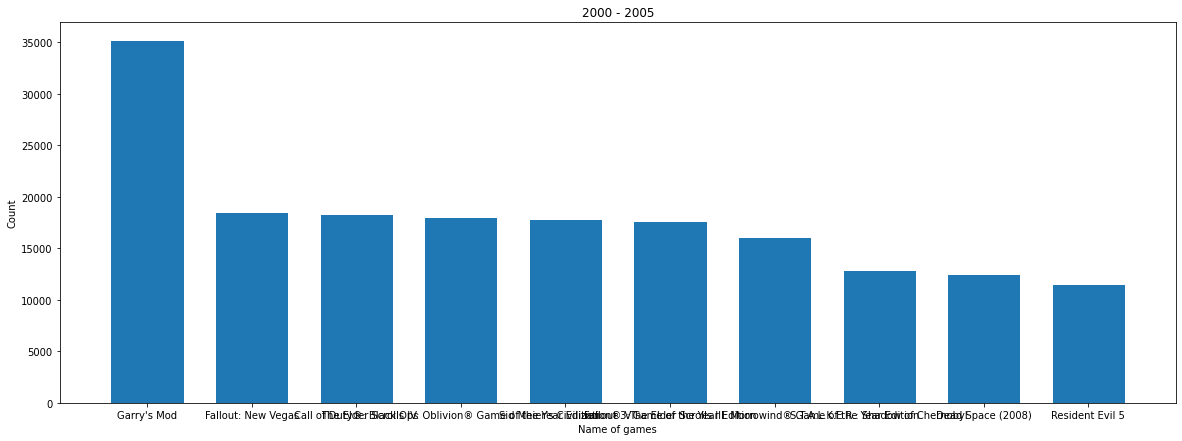

In [125]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(trend2['title'][:10],trend2["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("2000 - 2005")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

###2010's - 2015's 

In [126]:
trend4 = all_data.filter((f.year('date_release') > lit('2010')) &(f.year('date_release') <= lit('2015'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [127]:
trend4.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|Counter-Strike: G...|  2012-08-21|172407|
|  Grand Theft Auto V|  2015-04-13|148801|
|           Fallout 4|  2015-11-09|148530|
|              Arma 3|  2013-09-12|115925|
|       Path of Exile|  2013-10-23|111576|
|The Binding of Is...|  2014-11-04| 98643|
|        BeamNG.drive|  2015-05-29| 90970|
|Tom Clancy's Rain...|  2015-12-01| 67570|
|            PAYDAY 2|  2013-08-13| 63807|
|              Dota 2|  2013-07-09| 61358|
+--------------------+------------+------+
only showing top 10 rows



In [128]:
trend4 = trend4.toPandas()
trend4.head(10)

,title,date_release,count
0,Counter-Strike: Global Offensive,2012-08-21,172407
1,Grand Theft Auto V,2015-04-13,148801
2,Fallout 4,2015-11-09,148530
3,Arma 3,2013-09-12,115925
4,Path of Exile,2013-10-23,111576
5,The Binding of Isaac: Rebirth,2014-11-04,98643
6,BeamNG.drive,2015-05-29,90970
7,Tom Clancy's Rainbow Six® Siege,2015-12-01,67570
8,PAYDAY 2,2013-08-13,63807
9,Dota 2,2013-07-09,61358


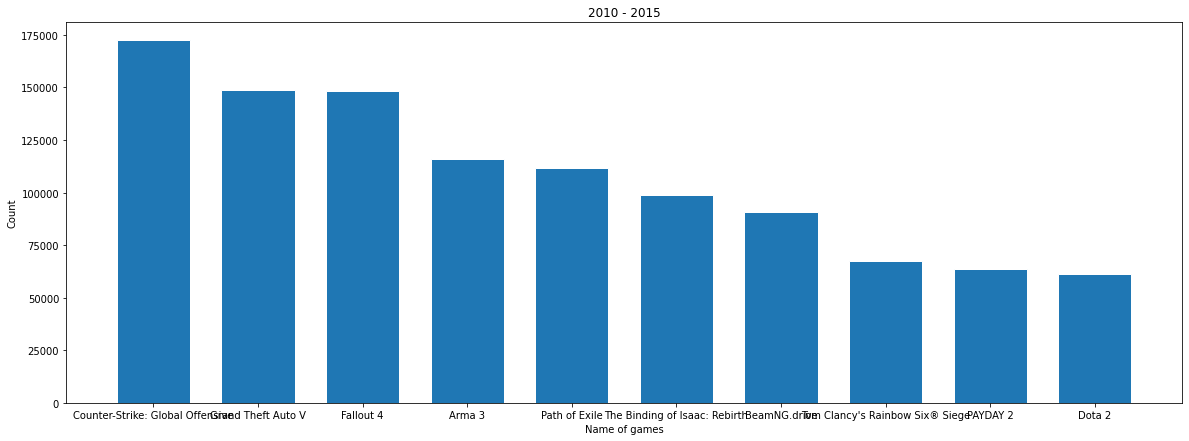

In [129]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(trend4['title'][:10],trend4["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("2010 - 2015")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### 2015's - 2020's

In [130]:
trend5 = all_data.filter((f.year('date_release') > lit('2015')) &(f.year('date_release') <= lit('2020'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [131]:
trend5.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|                Rust|  2018-02-08|251433|
|        No Man's Sky|  2016-08-12|150261|
|    Wallpaper Engine|  2018-11-01|149654|
|Red Dead Redempti...|  2019-12-05|117967|
|      Cyberpunk 2077|  2020-12-09|109328|
|      Sea of Thieves|  2020-06-03|108191|
|   Hearts of Iron IV|  2016-06-06|104751|
|          Brawlhalla|  2017-10-17| 99032|
|              VRChat|  2017-02-01| 87365|
|Sid Meier’s Civil...|  2016-10-20| 83188|
+--------------------+------------+------+
only showing top 10 rows



In [132]:
trend5 = trend5.toPandas()
trend5.head(10)

,title,date_release,count
0,Rust,2018-02-08,251433
1,No Man's Sky,2016-08-12,150261
2,Wallpaper Engine,2018-11-01,149654
3,Red Dead Redemption 2,2019-12-05,117967
4,Cyberpunk 2077,2020-12-09,109328
5,Sea of Thieves,2020-06-03,108191
6,Hearts of Iron IV,2016-06-06,104751
7,Brawlhalla,2017-10-17,99032
8,VRChat,2017-02-01,87365
9,Sid Meier’s Civilization® VI,2016-10-20,83188


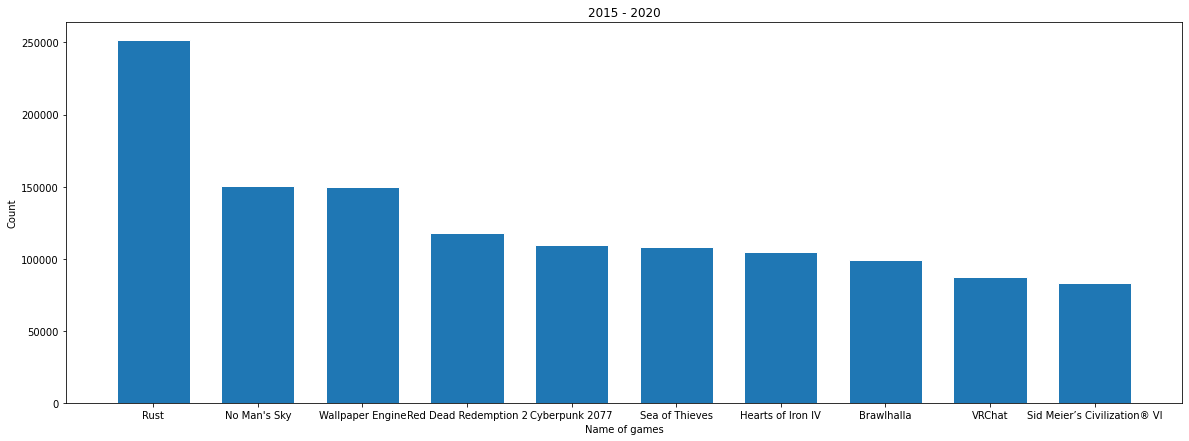

In [133]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(trend5['title'][:10],trend5["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("2015 - 2020")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### 2020

In [134]:
trend6 = all_data.filter((f.year('date_release') == lit('2020'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [135]:
trend6.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|      Cyberpunk 2077|  2020-12-09|109328|
|      Sea of Thieves|  2020-06-03|108191|
|        Satisfactory|  2020-06-08| 68495|
|       Borderlands 3|  2020-03-13| 50566|
|Grand Theft Auto ...|  2020-03-24| 47292|
|      Risk of Rain 2|  2020-08-11| 47229|
|       Apex Legends™|  2020-11-04| 45325|
|          Fallout 76|  2020-04-14| 42217|
|         The Sims™ 4|  2020-06-18| 40964|
|     Half-Life: Alyx|  2020-03-23| 37962|
+--------------------+------------+------+
only showing top 10 rows



In [136]:
trend6 = trend6.toPandas()
trend6.head(10)

,title,date_release,count
0,Cyberpunk 2077,2020-12-09,109328
1,Sea of Thieves,2020-06-03,108191
2,Satisfactory,2020-06-08,68495
3,Borderlands 3,2020-03-13,50566
4,Grand Theft Auto IV: The Complete Edition,2020-03-24,47292
5,Risk of Rain 2,2020-08-11,47229
6,Apex Legends™,2020-11-04,45325
7,Fallout 76,2020-04-14,42217
8,The Sims™ 4,2020-06-18,40964
9,Half-Life: Alyx,2020-03-23,37962


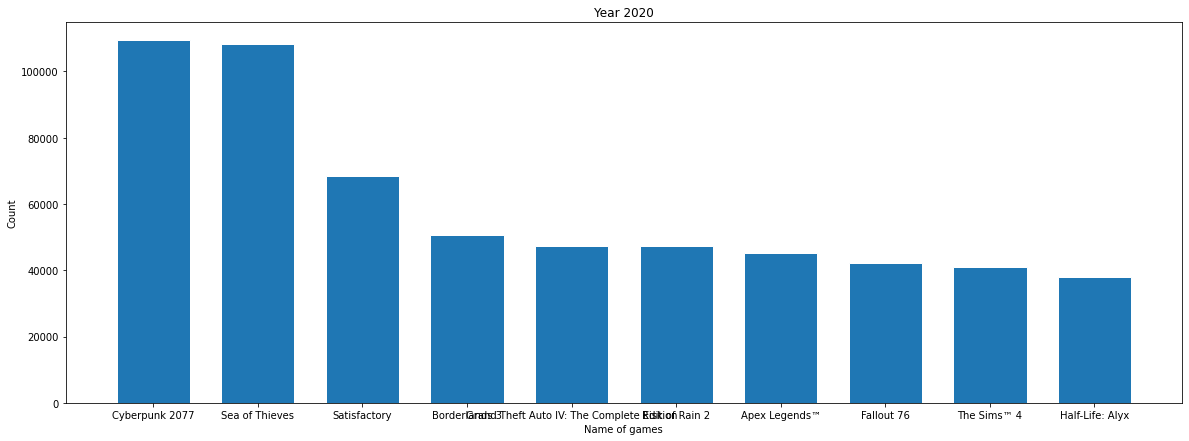

In [137]:
fig, ax = plt.subplots(figsize =(20,7))
ax.bar(trend6['title'][:10],trend6["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("Year 2020")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### 2021

In [138]:
trend7 = all_data.filter((f.year('date_release') == lit('2021'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [139]:
trend7.show(10)

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|         Inscryption|  2021-10-19|52982|
|        Ready or Not|  2021-12-17|50146|
|      Hell Let Loose|  2021-07-27|39860|
|           OUTRIDERS|  2021-04-01|36717|
|     Forza Horizon 4|  2021-03-09|31337|
|        It Takes Two|  2021-03-25|27817|
|                GTFO|  2021-12-09|25641|
|GUILTY GEAR -STRIVE-|  2021-06-11|25488|
|       Halo Infinite|  2021-11-15|21899|
|              DEVOUR|  2021-01-28|18597|
+--------------------+------------+-----+
only showing top 10 rows



In [140]:
trend7 = trend7.toPandas()
trend7.head(10)

,title,date_release,count
0,Inscryption,2021-10-19,52982
1,Ready or Not,2021-12-17,50146
2,Hell Let Loose,2021-07-27,39860
3,OUTRIDERS,2021-04-01,36717
4,Forza Horizon 4,2021-03-09,31337
5,It Takes Two,2021-03-25,27817
6,GTFO,2021-12-09,25641
7,GUILTY GEAR -STRIVE-,2021-06-11,25488
8,Halo Infinite,2021-11-15,21899
9,DEVOUR,2021-01-28,18597


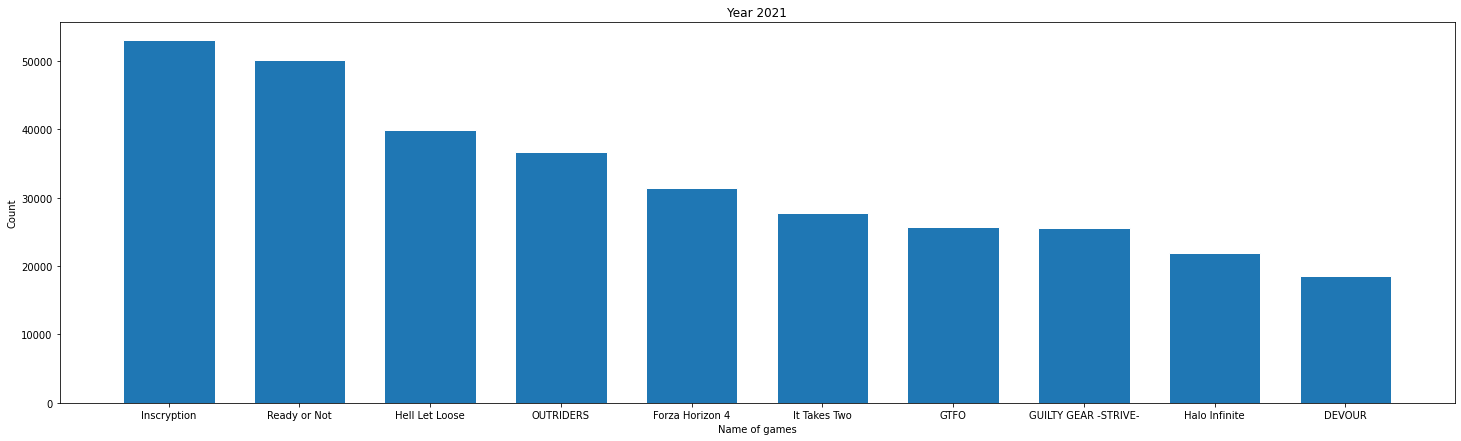

In [141]:
fig, ax = plt.subplots(figsize =(25,7))
ax.bar(trend7['title'][:10],trend7["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("Year 2021")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()

### 2022

In [142]:
trend8 = all_data.filter((f.year('date_release') == lit('2022'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [143]:
trend8.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|Call of Duty®: Mo...|  2022-10-27|131361|
|            Lost Ark|  2022-02-11| 94162|
|               Stray|  2022-07-19| 56284|
|Dying Light 2 Sta...|  2022-02-03| 55244|
|          ELDEN RING|  2022-02-24| 55120|
|Mount & Blade II:...|  2022-10-25| 54219|
|   Vampire Survivors|  2022-10-20| 43523|
|Warhammer 40000: ...|  2022-11-30| 38637|
|Total War: WARHAM...|  2022-02-16| 32226|
|Marvel’s Spider-M...|  2022-08-12| 31048|
+--------------------+------------+------+
only showing top 10 rows



In [144]:
trend8 = trend8.toPandas()
trend8.head(10)

,title,date_release,count
0,Call of Duty®: Modern Warfare® II,2022-10-27,131361
1,Lost Ark,2022-02-11,94162
2,Stray,2022-07-19,56284
3,Dying Light 2 Stay Human,2022-02-03,55244
4,ELDEN RING,2022-02-24,55120
5,Mount & Blade II: Bannerlord,2022-10-25,54219
6,Vampire Survivors,2022-10-20,43523
7,Warhammer 40000: Darktide,2022-11-30,38637
8,Total War: WARHAMMER III,2022-02-16,32226
9,Marvel’s Spider-Man Remastered,2022-08-12,31048


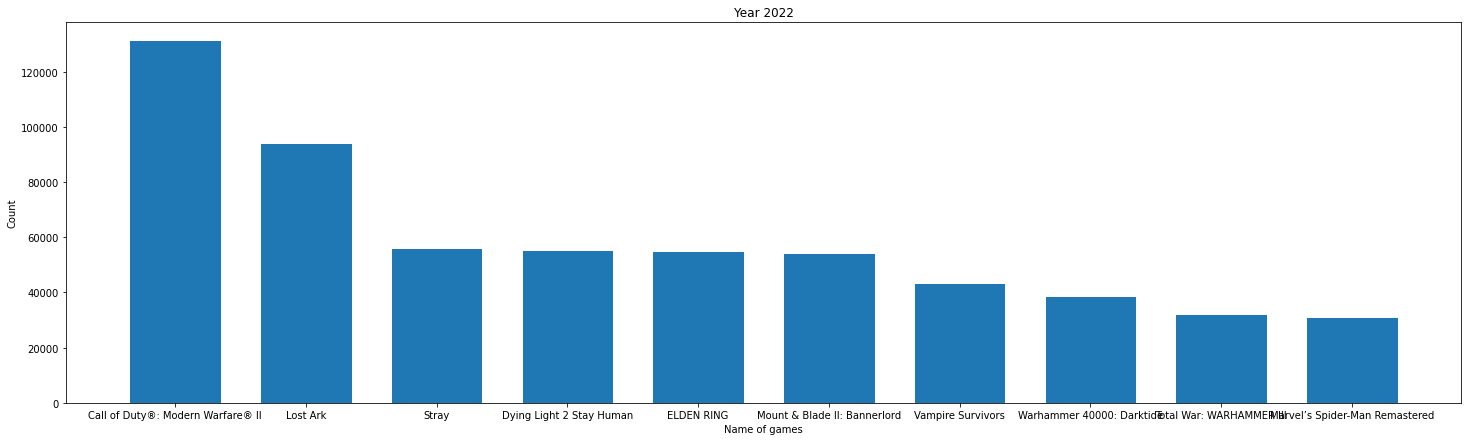

In [145]:
fig, ax = plt.subplots(figsize =(25,7))
ax.bar(trend8['title'][:10],trend8["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))
plt.title("Year 2022")
plt.xlabel('Name of games')
plt.ylabel('Count')
plt.show()